# Buckling and post-buckling of an hyperelastic beam

In [1]:
from dolfin import *
from mshr import *
import ufl 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from slepc4py import SLEPc
from slepc_eigensolver import EigenSolver

%matplotlib inline
plt.style.use('seaborn-notebook')

## Hyperelastic problem formulation

We define the hyperelastic problem for a rectangular slab under its own weight, as done in other notebook.
We set also a standard newton solver

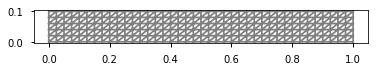

In [2]:
# Create mesh and define boundaries fof BCs
nu = 0.3
nx = 40
ny = 5 
Lx = 1 
Ly = 0.1*Lx
degree = 2

mesh = dolfin.RectangleMesh(dolfin.Point(0, 0), dolfin.Point(Lx, Ly), nx, ny)
left = dolfin.CompiledSubDomain("near(x[0], 0) && on_boundary")
right = dolfin.CompiledSubDomain("near(x[0], Lx) && on_boundary", Lx=Lx)
boundary_markers = dolfin.MeshFunction("size_t", mesh, dim=1, value=0)
left_index = 1
right_index = 2
left.mark(boundary_markers, left_index)
right.mark(boundary_markers, right_index)
ds = dolfin.ds(domain=mesh,subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)

V_element = dolfin.VectorElement('CG', ufl.triangle, degree=degree, dim=2) 
V = dolfin.FunctionSpace(mesh, V_element)
u = dolfin.Function(V, name="u")

I = ufl.Identity(2)
F = ufl.variable(I + ufl.grad(u))  
C = F.T*F                   
Ic = ufl.tr(C)
J  = ufl.det(F)
E = 1/2*(C-I)
Y = 1.e3
mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
lmbda = 2*lmbda*mu/(lmbda + 2*mu) 
psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lmbda/2)*(ufl.ln(J))**2

Gamma = 7.84
rho_g = Gamma * Y * Ly**2 / 12 / Lx**3
b0 = dolfin.Expression(("-t * rho_g * cos(alpha)", "t * rho_g * sin(alpha)"),
                       t=0, alpha=0, rho_g=rho_g, degree=0)
    
g0 = mu*dolfin.Constant((0.0,0.0)) 

potential_energy = psi*dx - ufl.dot(b0, u)*dx - ufl.dot(g0, u)*ds(2)
residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V))
jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V))
bcs = [dolfin.DirichletBC(V, (0., 0.), left)]
problem = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)
solver = dolfin.NonlinearVariationalSolver(problem)

u.interpolate(dolfin.Constant((0.,0.)))

dolfin.plot(mesh)

## How to compute the eigenvalues of the eigenvectors of the Hessian matrix

The stability depends on the minimal eigenvalue of the Hessian matrix, obtained by assembling the bilinear form `ddE` above (the second derivative of the energy). 

Here, as an example, we calculate them for the undeformed configuration  `u=0`.

To this end we use the class `EigenSolver` of the module `slepc_eigensolver`.

---- setting additional slepc options -----
     eps_max_it : 100
Solution method: krylovschur, stopping condition: tol=1e-08, maxit=100
Number of converged/requested eigenvalues with 1 iterations  : 8/6
The smallest eigenvalues are 
 [1.12673012e-03 4.04623992e-02 2.77596897e-01 2.80055530e-01
 9.22464698e-01 2.14021020e+00 2.49479913e+00 4.04690493e+00]
saved eigenvectors in  results/eigenvectors-0.pvd


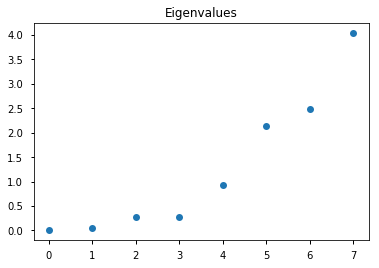

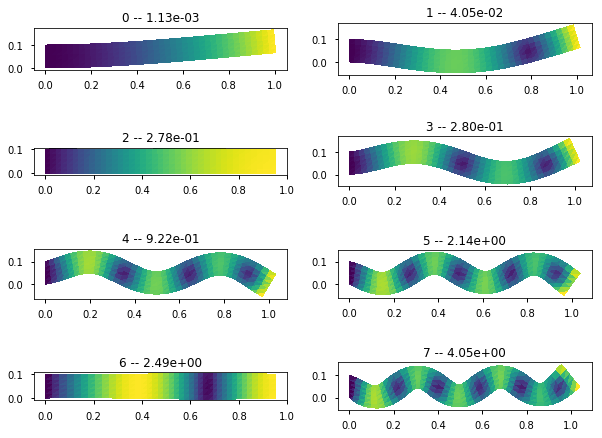

In [3]:
u.assign(interpolate(Constant(("0","0")),V))
neig = 6
eig_solver = EigenSolver(jacobian,u,bcs=bcs)
ncv, it = eig_solver.solve(neig,verbose=True)
eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(ncv)
print("The smallest eigenvalues are \n", eigenvalues.real)

# save the eigenvectors tp a file that can be opened in paraview
eig_solver.save_eigenvectors(ncv, 'results/eigenvectors-0.pvd')

# plot the eigenvalues
plt.figure()
plt.plot(eigenvalues.real,'o')
plt.title("Eigenvalues")

# plot the eigenvectors
figure = plt.figure(figsize = (10, 10))
for i in range(ncv):
    plt.subplot(int(ncv/2+1),2,i+1)
    dolfin.plot(eigenvectors_real[i],mode='displacement')
    plt.title("{:d} -- {:2.2e}".format(i,eigenvalues[i].real))

## Nonlinear quasi-static evolution with stability check

We compute here a quasi-static evolution obtained when increasing the loading parameter `t`.

At each time step:
    
    - We compute the solution using a Newton solver, using the solution at the previous time-step as initial guess
    
    - We check the stability of the solution, by computing the smallest eigenvalue of the second derivative of the energy

    For the stability check, we define the following function returning the smallest eigenvalue of a bilinear form with given Dirichlet boundary conditions

In [4]:
def stability_monitor(ddE, u, bcs, neig=2,verbose=True):
    eig_solver = EigenSolver(ddE, u, bcs=bcs)
    ncv, it = eig_solver.solve(neig,verbose=verbose) 
    eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(ncv)
    min_eig = min(eigenvalues.real)
    return min_eig
    
stability_monitor(jacobian, u, bcs, neig=2)

---- setting additional slepc options -----
     eps_max_it : 100
Solution method: krylovschur, stopping condition: tol=1e-08, maxit=100
Number of converged/requested eigenvalues with 1 iterations  : 6/2


0.0011267301171570807

No handles with labels found to put in legend.


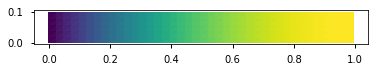

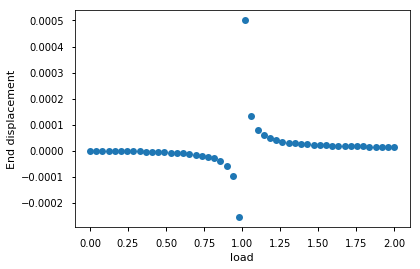

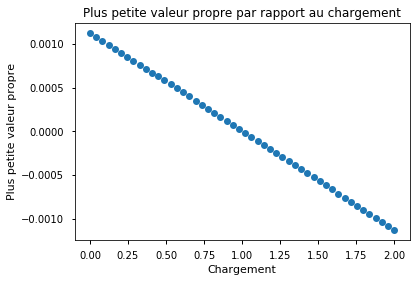

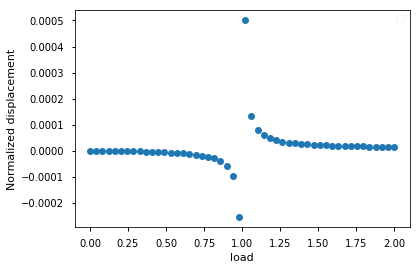

In [5]:
u.assign(Constant((0., 0.)))
loads = np.linspace(0., 2., 50)
norm_displ = np.zeros_like(loads)
forces = 0. * loads
displ = 0. * loads
min_eig = 0. * loads
u.rename("u","u")

b0.alpha = 0

file_u = File("results/nonlinear_compression.pvd");
for (i,t) in enumerate(loads):
    b0.t = t 
    # solve the problem
    solver.solve()
    # compute the smallest eigenvalue
    min_eig[i] = stability_monitor(jacobian, u, bcs, neig=2,verbose=False)
    # force and end displacement
    displ[i] = dolfin.assemble(u[1]*ds(2))/Ly # average displacement of the right end
    norm_displ[i] = displ[i]/Lx
    file_u << (u,t)
    
    
plt.figure(0)
plot(u, mode = "displacement")

plt.figure(1)
plt.plot(loads,displ,"o")
plt.xlabel("load")
plt.ylabel("End displacement")

plt.figure(2)
plt.plot(loads,min_eig,"o",label='alpha = 0')
plt.xlabel("Chargement")
plt.ylabel("Plus petite valeur propre")
plt.title("Plus petite valeur propre par rapport au chargement")

plt.figure(3)
plt.plot(loads,norm_displ,"o")
plt.xlabel("load")
plt.ylabel("Normalized displacement")
plt.legend()

### Part I: Nonlinear quasi-static response analysis

#### Question I.1: 
Set Ly = 0.1 * Lx, α = 0.1 and plot the normalized deflection u_L / Lx at the free end as a function of t, for 0 ≤ t ≤ 2. Interpret the results.

Text(0.5,1,"Influence de l'angle sur de déplacement normalisé de la pointe")

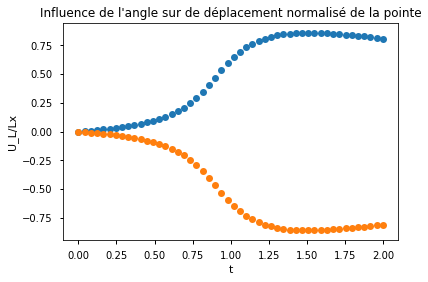

In [6]:
Lx = 1.
E = 1000
nu = 0.3
Ly = 0.1 * Lx
alpha = 0.1
displ1 = 0. * loads
displ2 = 0. * loads

# alpha = 0.1
b0.alpha = 0.1
u.assign(dolfin.Constant((0.,0.)))
for (i,t) in enumerate (loads):
    b0.t = t
    solver.solve()
    displ1[i] = dolfin.assemble(u[1]*ds(2))/Ly
    file_u << (u,t)
    
# alpha = -0.1
b0.alpha = -0.1
u.assign(dolfin.Constant((0.,0.)))
for (i,t) in enumerate (loads):
    b0.t = t
    solver.solve()
    displ2[i] = dolfin.assemble(u[1]*ds(2))/Ly
    file_u << (u,t)
    
plt.plot(loads,displ1/Lx,"o")
plt.plot(loads,displ2/Lx,"o")
plt.xlabel("t")
plt.ylabel("U_L/Lx")
plt.title("Influence de l'angle sur de déplacement normalisé de la pointe")

#### Question I.2: 
Discuss the influence of the imperfection α on the diagram: for example how the bifurcation curve is affected by α.

In [7]:
# Different values of alpha

displ3 = 0. * loads
displ4 = 0. * loads
displ5 = 0. * loads
displ6 = 0. * loads
displ7 = 0. * loads
displ8 = 0. * loads
displ9 = 0. * loads

min_eig3 = 0. * loads
min_eig4 = 0. * loads
min_eig5 = 0. * loads
min_eig6 = 0. * loads
min_eig7 = 0. * loads
min_eig8 = 0. * loads
min_eig9 = 0. * loads

# alpha = 0
b0.alpha = 0
u.assign(dolfin.Constant((0.,0.)))
for (i,t) in enumerate (loads):
    b0.t = t
    solver.solve()
    displ3[i] = dolfin.assemble(u[1]*ds(2))/Ly
    min_eig3[i] = stability_monitor(jacobian, u, bcs, neig=2,verbose=False)
    file_u << (u,t)
    
# alpha = 0.5
b0.alpha = 0.5
u.assign(dolfin.Constant((0.,0.)))
for (i,t) in enumerate (loads):
    b0.t = t
    solver.solve()
    displ4[i] = dolfin.assemble(u[1]*ds(2))/Ly
    min_eig4[i] = stability_monitor(jacobian, u, bcs, neig=2,verbose=False)
    file_u << (u,t)
    
# alpha = -0.5
b0.alpha = -0.5
u.assign(dolfin.Constant((0.,0.)))
for (i,t) in enumerate (loads):
    b0.t = t
    solver.solve()
    displ5[i] = dolfin.assemble(u[1]*ds(2))/Ly
    min_eig5[i] = stability_monitor(jacobian, u, bcs, neig=2,verbose=False)
    file_u << (u,t)
    
# alpha = 0.05
b0.alpha = 0.05
u.assign(dolfin.Constant((0.,0.)))
for (i,t) in enumerate (loads):
    b0.t = t
    solver.solve()
    displ6[i] = dolfin.assemble(u[1]*ds(2))/Ly
    min_eig6[i] = stability_monitor(jacobian, u, bcs, neig=2,verbose=False)
    file_u << (u,t)
    
# alpha = -0.05
b0.alpha = -0.05
u.assign(dolfin.Constant((0.,0.)))
for (i,t) in enumerate (loads):
    b0.t = t
    solver.solve()
    displ7[i] = dolfin.assemble(u[1]*ds(2))/Ly
    min_eig7[i] = stability_monitor(jacobian, u, bcs, neig=2,verbose=False)
    file_u << (u,t)
    
# alpha = 0.005
b0.alpha = 0.005
u.assign(dolfin.Constant((0.,0.)))
for (i,t) in enumerate (loads):
    b0.t = t
    solver.solve()
    displ8[i] = dolfin.assemble(u[1]*ds(2))/Ly
    min_eig8[i] = stability_monitor(jacobian, u, bcs, neig=2,verbose=False)
    file_u << (u,t)
    
# alpha = -0.005
b0.alpha = -0.005
u.assign(dolfin.Constant((0.,0.)))
for (i,t) in enumerate (loads):
    b0.t = t
    solver.solve()
    displ9[i] = dolfin.assemble(u[1]*ds(2))/Ly
    min_eig9[i] = stability_monitor(jacobian, u, bcs, neig=2,verbose=False)
    file_u << (u,t)

Text(0.5,1,"Influence de l'angle sur de déplacement normalisé de la pointe")

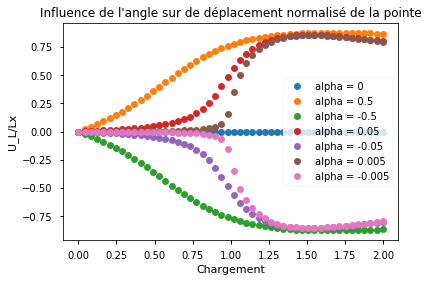

In [8]:
plt.plot(loads,displ3/Lx,"o",label='alpha = 0')
plt.plot(loads,displ4/Lx,"o",label='alpha = 0.5')
plt.plot(loads,displ5/Lx,"o",label='alpha = -0.5')
plt.plot(loads,displ6/Lx,"o",label='alpha = 0.05')
plt.plot(loads,displ7/Lx,"o",label='alpha = -0.05')
plt.plot(loads,displ8/Lx,"o",label='alpha = 0.005')
plt.plot(loads,displ9/Lx,"o",label='alpha = -0.005')
plt.legend()
plt.xlabel("Chargement")
plt.ylabel("U_L/Lx")
plt.title("Influence de l'angle sur de déplacement normalisé de la pointe")

Text(0.5,1,'Plus petite valeur propre par rapport au chargement')

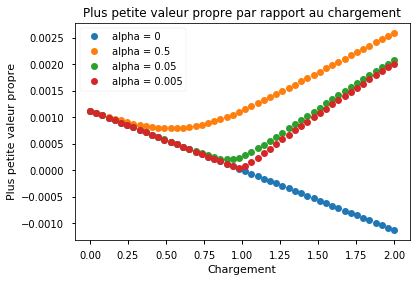

In [9]:
plt.plot(loads,min_eig3,"o",label='alpha = 0')
plt.plot(loads,min_eig4,"o",label='alpha = 0.5')
plt.plot(loads,min_eig6,"o",label='alpha = 0.05')
plt.plot(loads,min_eig8,"o",label='alpha = 0.005')
plt.legend()
plt.xlabel("Chargement")
plt.ylabel("Plus petite valeur propre")
plt.title("Plus petite valeur propre par rapport au chargement")

### Part II. Stability analysis

By studying the sign of the smallest eigenvalue of the hessian matrix, study the stability of the three branches
in the bifurcation diagram given in part I. Produce a figure where each branch is coloured in red if unstable and
in green if stable. 

The stability limit of the fundamental branch coincides with the first buckling load. Why? Are you able to prove it?

Text(0.5,1,'Stabilité du diagramme de bifurcation')

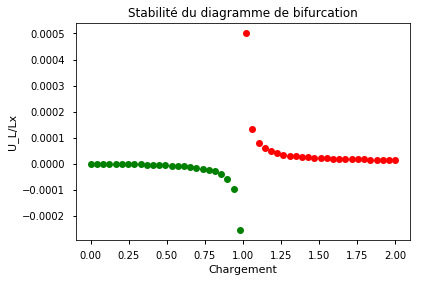

In [10]:
for i in range (len(loads)):
    if min_eig[i] < 0:
        plt.plot(loads[i],displ[i]/Lx,"ro")
    if min_eig[i] > 0:
        plt.plot(loads[i],displ[i]/Lx,"go")
plt.xlabel("Chargement")
plt.ylabel("U_L/Lx")
plt.title("Stabilité du diagramme de bifurcation")

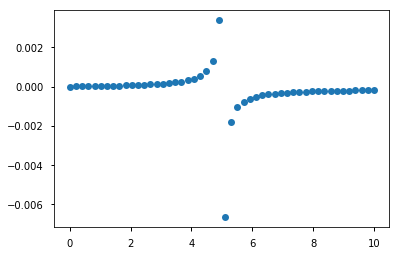

In [11]:
loads2 = np.linspace(0., 10., 50)
displ10 = 0. * loads2

b0.alpha = 0.0001
u.assign(dolfin.Constant((0.,0.)))

for (i,t) in enumerate (loads):
    b0.t = t
    solver.solve()
    displ10[i] = dolfin.assemble(u[1]*ds(2))/Ly
    file_u << (u,t)
    
plt.plot(loads2,displ10/Lx,"o",label='alpha = 0')

### Part III: Going further

We now use parameters value for concrete g = 9.81 (SI), E = 35GPa, α = 0.005rad, density ρ = 2400kg/m³, and compressive strength fc = 50MPa.

#### Question III.1:

For a pylon with base Ly = 10m, what is the height Lx for which we reach Γ = 7.8?

In [12]:
g = 9.81
E = 35E9
alpha = 0.005
rho = 2400
fc = 50E6
Ly = 10

Lx = ((E*(Ly**2)*7.8)/(12*rho*g))**(1/3)

print("Lx =",Lx,"m")

Lx = 458.8813253245298 m


#### Question III.2:
For a pylon with base Ly = 10m, what is the maximum height Lx? Is this limition due to tension or compression? Compare to the value found in Part I. Comment.

1. Limit in traction:

$$ Lx \left(1 - 3 \alpha \frac{Lx}{Ly}\right) > 0 $$

2. Limit in compression:

$$ Lx \left(1 + 3 \alpha \frac{Lx}{Ly}\right) < \frac{fc}{\rho g} $$

In [13]:
# Traction

coeff_t = [-3*alpha/Ly,1.,0.]
roots_t = np.roots(coeff_t)
print("First root in traction:",roots_t[0])
print("Second root in traction:",roots_t[1])

First root in traction: 666.6666666666666
Second root in traction: 0.0


In [14]:
# Compression

coeff_c = [3*alpha/Ly,1,-fc/(rho*g)]
roots_c = np.roots(coeff_c)
print("First root in compression:",roots_c[0])
print("Second root in compression:",roots_c[1])

First root in compression: -1569.0112803218228
Second root in compression: 902.3446136551566


#### Question III.3: 
For a pylon with base Ly = 20m, what is the height Lx for which we reach Γ = 7.8?

In [15]:
Ly2 = 20
Lx = ((E*(Ly**2)*7.8)/(12*rho*g))**(1/3)

print("Lx =",Lx,"m")

Lx = 458.8813253245298 m


#### Question III.4: 
For a pylon with base Ly = 20m, what is the height Lx for which the limitation is due to tension? Due to compression? Compare to the value found in Part I. Comment.

In [16]:
# Traction

coeff_t = [-3*alpha/Ly,1.,0.]
roots_t = np.roots(coeff_t)
print("First root in traction:",roots_t[0])
print("Second root in traction:",roots_t[1])

First root in traction: 666.6666666666666
Second root in traction: 0.0


In [17]:
# Compression

coeff_c = [3*alpha/Ly,1,-fc/(rho*g)]
roots_c = np.roots(coeff_c)
print("First root in compression:",roots_c[0])
print("Second root in compression:",roots_c[1])

First root in compression: -1569.0112803218228
Second root in compression: 902.3446136551566


### Plot security zone

In [18]:
alpha_p = 0.005
rho_p = 2400
g_p = 9.18
fc_p = 50E6
p_p = fc/(rho*g)

Lx_p = np.linspace(0.0, 2000., 50)

Text(0.5,1,'Zone de sécurité du pylône')

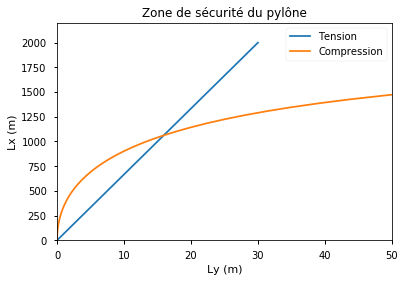

In [19]:
plt.plot(3*alpha_p*Lx_p,Lx_p,label = "Tension")
plt.plot(((3*alpha_p*Lx_p**2)/(p_p-Lx_p)),Lx_p,label = "Compression")
plt.xlabel("Ly (m)")
plt.ylabel("Lx (m)")
plt.axis([0, 50, 0, 2200])
plt.legend()
plt.title("Zone de sécurité du pylône")